<a href="https://colab.research.google.com/github/woncoh1/era1a7/blob/main/nbs/S7_01_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Summary of targets, results, and analysis

## Targets
- Set up the overall training program
- Test our first model skeleton

## Results
- Best accuracy
    - Train = 99.74 %
    - [ ] Test = 99.30 %
- [ ] Number of Parameters = 8,728
- [x] Number of Epochs = 15

## Analysis
- We failed to touched 99.4 % accuracy, but 99.3 % is not bad for a first attempt.
- Starting from the second half of the training epochs, we witness slight over-fitting, which tends to grow more pronounced towards the end of training.
- Number of parameters is good, but we can do better. We will focus on model complexity later in box 2.
- Since both test accuracy and model size is unsatisfactory, we may use the next step to improve our model skeleton (architecture, structure, etc). I think it will be better to tackle the skeleton early on and commit to the best one before we tweak other aspects of training.
- I don't like the followings:
    - Max pooling: there are 2 max pooling layers, so there are 3 blocks, each for edges gradients, textures and patterns, and objects (i.e. digits). Do we actually need 3 blocks for digit recognition? Can we reduce the number of max pool layers to 1? Also, I want the last max pool layer move further away from the final prediction layer.
    - Padding: Do we need padding=1? Even if we use padding_mode=replicate, we still introduce information, which I don't like. Since the image size is small (28x28), it may be possible to get rid of all paddings.

>[Summary](#scrollTo=kjFgf9woqfAE)

>>[Targets](#scrollTo=kjFgf9woqfAE)

>>[Results](#scrollTo=kjFgf9woqfAE)

>>[Analysis](#scrollTo=kjFgf9woqfAE)

>[Device](#scrollTo=7QlJ9s_43tj4)

>>[Colab](#scrollTo=_qZEo7Ty13uh)

>>[Pytorch](#scrollTo=30q5EOnt11t3)

>[Data](#scrollTo=IZlN9TTM3yVC)

>>[Transform](#scrollTo=lDnD-zELz8as)

>>[Dataset](#scrollTo=N4NSVJ0DwivZ)

>>[DataLoader](#scrollTo=vb2R5ZBFzi08)

>>[Inspect](#scrollTo=WD-_p0o7PQN_)

>[Model](#scrollTo=5v1EC4vo3upW)

>[Trainer](#scrollTo=_KvOD_jk3zrp)

>>[Learning-rate finder](#scrollTo=pLdoCYstSAxO)

>[Evaluate](#scrollTo=BoqfYvTXUPFb)



In [1]:
!git clone https://github.com/woncoh1/era1a7.git

Cloning into 'era1a7'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 67 (delta 36), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), 22.73 KiB | 1.34 MiB/s, done.


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary

from era1a7 import data, models, engine, utils

In [3]:
torch.manual_seed(1)

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.ToTensor(), # Standardization
        transforms.Normalize((0.1307,), (0.3081,)), # Normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]),
}

## Dataset

In [6]:
dataset = data.get_dataset(transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 275478136.02it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26889166.22it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 148183912.85it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## DataLoader

In [7]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [8]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

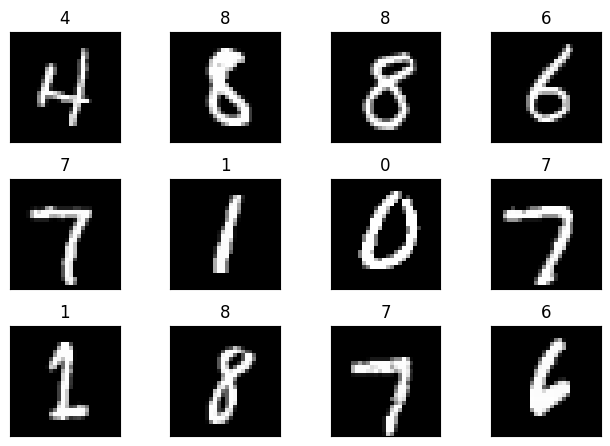

In [9]:
utils.inspect_batch(loader['train'])

# Model

In [10]:
criterion = F.nll_loss
model = models.Model0().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1, 16,

# Trainer

In [11]:
params_trainer = {
    'num_epochs': 15,
}
params_optimizer = {
    'lr': 0.5,
    'momentum': 0.9,
}
params_scheduler = {
    'step_size': 10,
    'gamma': 0.1,
    'verbose': True,
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

Adjusting learning rate of group 0 to 5.0000e-01.


  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00125, Accuracy = 94.97%, Epoch = 1
Test : Loss = 0.00052, Accuracy = 97.97%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00049, Accuracy = 98.03%, Epoch = 2
Test : Loss = 0.00052, Accuracy = 97.82%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00036, Accuracy = 98.55%, Epoch = 3
Test : Loss = 0.00029, Accuracy = 98.88%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00033, Accuracy = 98.72%, Epoch = 4
Test : Loss = 0.00032, Accuracy = 98.80%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00028, Accuracy = 98.84%, Epoch = 5
Test : Loss = 0.00027, Accuracy = 98.87%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00027, Accuracy = 98.88%, Epoch = 6
Test : Loss = 0.00029, Accuracy = 98.85%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00025, Accuracy = 98.98%, Epoch = 7
Test : Loss = 0.00027, Accuracy = 98.86%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00021, Accuracy = 99.13%, Epoch = 8
Test : Loss = 0.00026, Accuracy = 98.97%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00021, Accuracy = 99.16%, Epoch = 9
Test : Loss = 0.00019, Accuracy = 99.26%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00020, Accuracy = 99.18%, Epoch = 10
Test : Loss = 0.00026, Accuracy = 98.89%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00011, Accuracy = 99.57%, Epoch = 11
Test : Loss = 0.00018, Accuracy = 99.29%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00009, Accuracy = 99.67%, Epoch = 12
Test : Loss = 0.00017, Accuracy = 99.29%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00008, Accuracy = 99.66%, Epoch = 13
Test : Loss = 0.00018, Accuracy = 99.27%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00007, Accuracy = 99.72%, Epoch = 14
Test : Loss = 0.00017, Accuracy = 99.30%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00007, Accuracy = 99.74%, Epoch = 15
Test : Loss = 0.00018, Accuracy = 99.30%



# Evaluate

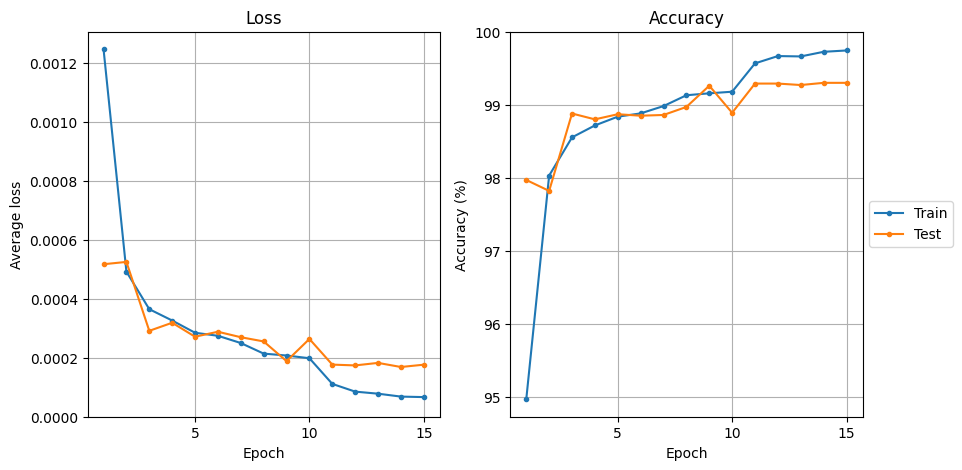

In [12]:
utils.plot_curves(results)

In [13]:
# Live prediction demo

In [14]:
# Wrong prediction demo